In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


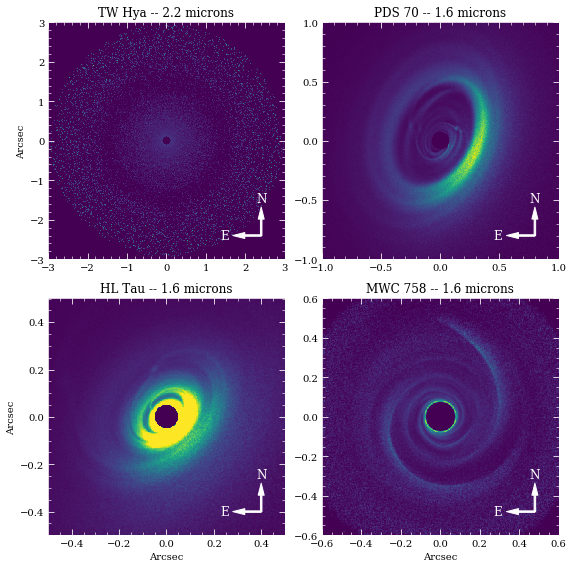

In [82]:
from astropy.io import fits
import matplotlib.colors as colors
outdir  = 'YSOs/'

fits_names = ['TW Hya', 'PDS 70', 'HL Tau', 'MWC 758']
fits_files =  ['model_'+f.replace(" ", "")+'.fits' for f in fits_names]

fig, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.flatten()


for i, file in enumerate(fits_files):
    hdul = fits.open(outdir + file)

    # Data is in million Jy per Steradian
    data = hdul[0].data
    if 'TWHya' in file:
        data_wave = 2.2 # micons
        pa_offset = 0
        pix_asec = 0.010 # Arcsec/pixel
        rmask = 0.1
        xy = np.array([-1,1])*3
    elif 'MWC758' in file:
        data_wave = 1.6 # micons
        pa_offset = 215
        pix_asec = 0.0034
        rmask = 0.05
        xy = np.array([-1,1])*0.6
    elif 'SAO206462' in file:
        data_wave = 1.6 # micons
        pa_offset = 180
        pix_asec = 0.004
        rmask = 0.1
        xy = np.array([-1,1])
    elif 'HLTau' in file:
        data_wave = 1.6 # micons
        pa_offset = 315
        pix_asec = 0.0031
        rmask = 0.05
        xy = np.array([-1,1])*0.5
    elif 'PDS70' in file:
        data_wave = 1.6 # micons
        pa_offset = 295
        pix_asec = 0.0045
        rmask = 0.075
        xy = np.array([-1,1])
        
    # Steradians to square arcsec
    sr_to_asec2 = (3600*180/np.pi)**2

    # Data in Jy/arcsec^2
    data *= (1e9 * pix_asec**2 / sr_to_asec2) # mJy / pixel

    
    # Mask inner disk region
    rho = nrc_utils.dist_image(data, pixscale=pix_asec)
    data[rho<=rmask] = 0

    hdul[0].data = nrc_utils.rotate_offset(data, pa_offset, reshape=False)
    if 'MWC758' in file:
        hdul[0].data = hdul[0].data[:,::-1]

    if ('TWHya' in file) or ('MWC758' in file) or ('SAO206462' in file):
        hdul[0].data = hdul[0].data * rho**2
        
    #args_disk = (hdul, pix_asec, dist_sci, data_wave, 'mJy/pixel')
    
    extent = np.array([-1,1,-1,1]) * hdul[0].data.shape[0] * pix_asec / 2
    
    ax = axes[i]
    vmax = 0.001 if 'HLTau' in file else np.max(hdul[0].data)
    ax.imshow(hdul[0].data, extent=extent, vmin=0, vmax=vmax)
    
    ax.set_xlim(xy)
    ax.set_ylim(xy)
    
    ax.set_title('{} -- {:.1f} microns'.format(fits_names[i], data_wave))


    
for i, ax in enumerate(axes):
    if i>1: ax.set_xlabel('Arcsec')
    if np.mod(i,2)==0: ax.set_ylabel('Arcsec')

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')

    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

        
    nrc_utils.plotAxes(ax, label1='E', label2='N', width=1.5, headwidth=6)
    

fig.tight_layout()

fname = "YSO_models.pdf"
fig.savefig(outdir+fname)

In [ ]:
np.mod()